# Exercise - plate tectonics
## Task description
In this exercise, we want to estimate how much the tectonic plates move, particularly, how much Europe and North America drift apart.

Therefore, we use GPS station coordinate time series.
One station is located in Europe, the other is located in North America.
Based on the trend of the baseline between these stations, the movement should be determined.

GPS data is used from the Nevada Geodetic Laboratory: http://geodesy.unr.edu/NGLStationPages/GlobalStationList

# Some background information

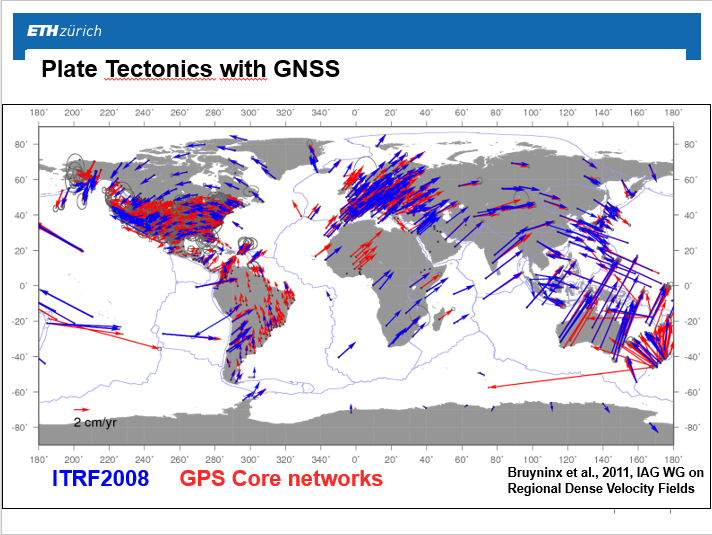

In [2]:
from IPython.display import Image
Image(filename='../Images/station_velocities.png')

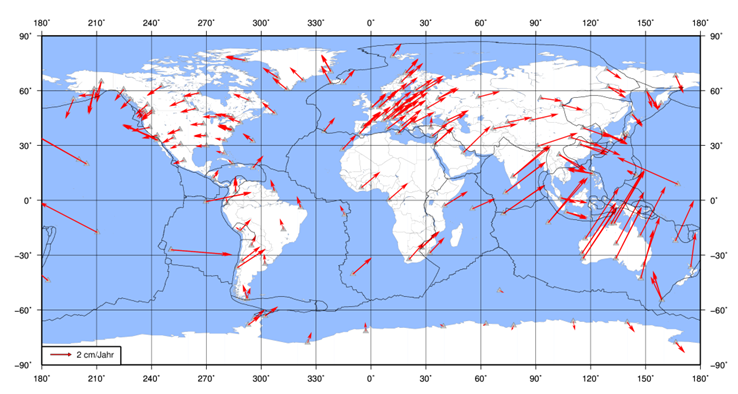

In [3]:
Image(filename='../Images/plate_tectonics.png')

# Let's start programming

In [1]:
# import packages
from pathlib import Path
import pandas as pd
import datetime
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.dates import date2num

In [2]:
# function to read the data
def read_txyz2(file):
    """
    This function reads .txyz2 files and returns a pd.DataFrame of the data.
    :param file: (PosixPath) path to .txyz2 file
    :return: (pd.DataFrame)
    """
    # read data (txyz2 format)
    dateparser = lambda x: datetime.datetime.strptime(x, '%y%b%d')
    df = pd.read_csv(file, delimiter=' ', skipinitialspace=True, index_col=1, parse_dates=True, date_parser=dateparser,
                     names=['station', 'decimal_year', 'x(m)', 'y(m)', 'z(m)', 'sig_x(m)', 'sig_y(m)', 'sig_z(m)',
                            'corr_xy', 'corr_yz', 'corr_xz', 'ant(m)'])
    df.name = file.stem

    return df

# Read in the data and inspect it

In [3]:
# read data - station Europe
file_stationEU = Path("../Data/CRCB.txyz2")
stationEU = read_txyz2(file=file_stationEU)
# read data - station North America
file_stationNA = Path("../Data/NJOC.txyz2")
stationNA = read_txyz2(file=file_stationNA)
# show first lines of data
stationNA.head()

station  decimal_year          x(m)          y(m)          z(m)  \
2006-07-03    NJOC     2006.5024  1.333637e+06 -4.710933e+06  4.073963e+06   
2006-07-05    NJOC     2006.5079  1.333637e+06 -4.710933e+06  4.073963e+06   
2006-07-09    NJOC     2006.5188  1.333637e+06 -4.710933e+06  4.073963e+06   
2006-07-10    NJOC     2006.5216  1.333637e+06 -4.710933e+06  4.073963e+06   
2006-07-11    NJOC     2006.5243  1.333637e+06 -4.710933e+06  4.073963e+06   

            sig_x(m)  sig_y(m)  sig_z(m)   corr_xy   corr_yz   corr_xz  ant(m)  
2006-07-03  0.001138  0.002677  0.002222 -0.658830 -0.837499  0.589540       0  
2006-07-05  0.001104  0.002575  0.002121 -0.646382 -0.834544  0.581390       0  
2006-07-09  0.001129  0.002641  0.002187 -0.650053 -0.835531  0.589176       0  
2006-07-10  0.001143  0.002695  0.002168 -0.662722 -0.838703  0.598855       0  
2006-07-11  0.001132  0.002713  0.002214 -0.644801 -0.836370  0.589366       0

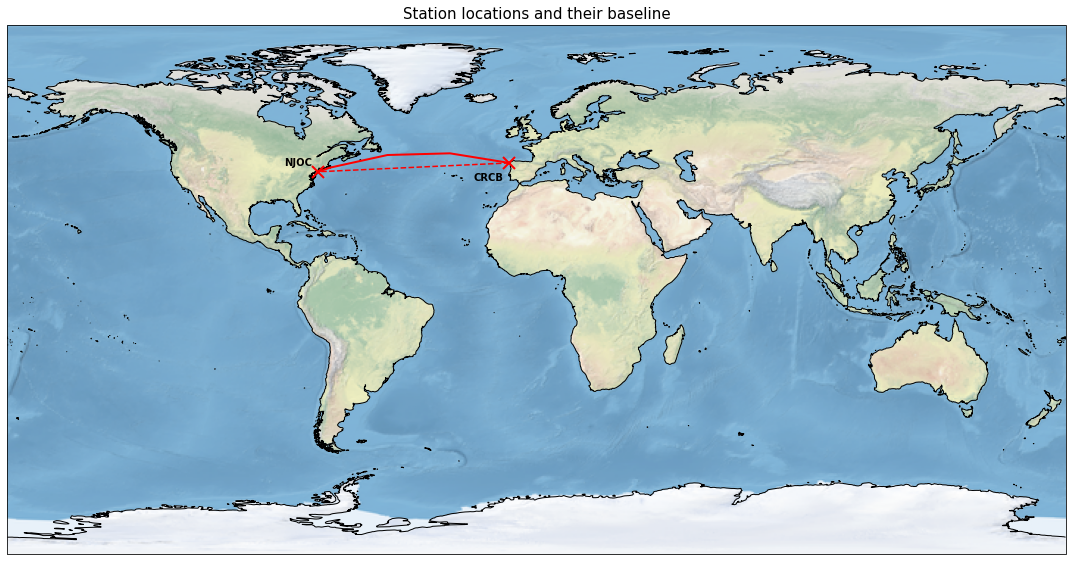

In [6]:
# plot map showing where stations are located
import cartopy.crs as ccrs

lonlatEU = (-9.190, 42.945)
lonlatNA = (-74.194, 39.953)

plt.figure(figsize=(15, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()

plt.plot([lonlatEU[0], lonlatNA[0]], [lonlatEU[1], lonlatNA[1]], color='r', linewidth=2, marker='x', markersize=12, markeredgewidth=2, transform=ccrs.Geodetic())
plt.plot([lonlatEU[0], lonlatNA[0]], [lonlatEU[1], lonlatNA[1]], color='r', linestyle='--', transform=ccrs.PlateCarree())
plt.text(lonlatEU[0] - 2, lonlatEU[1] - 6, stationEU.name, horizontalalignment='right', weight='bold', transform=ccrs.Geodetic())
plt.text(lonlatNA[0] - 2, lonlatNA[1] + 2, stationNA.name, horizontalalignment='right', weight='bold', transform=ccrs.Geodetic())
ax.coastlines(resolution='50m')
plt.title('Station locations and their baseline', fontsize=15)
plt.tight_layout()

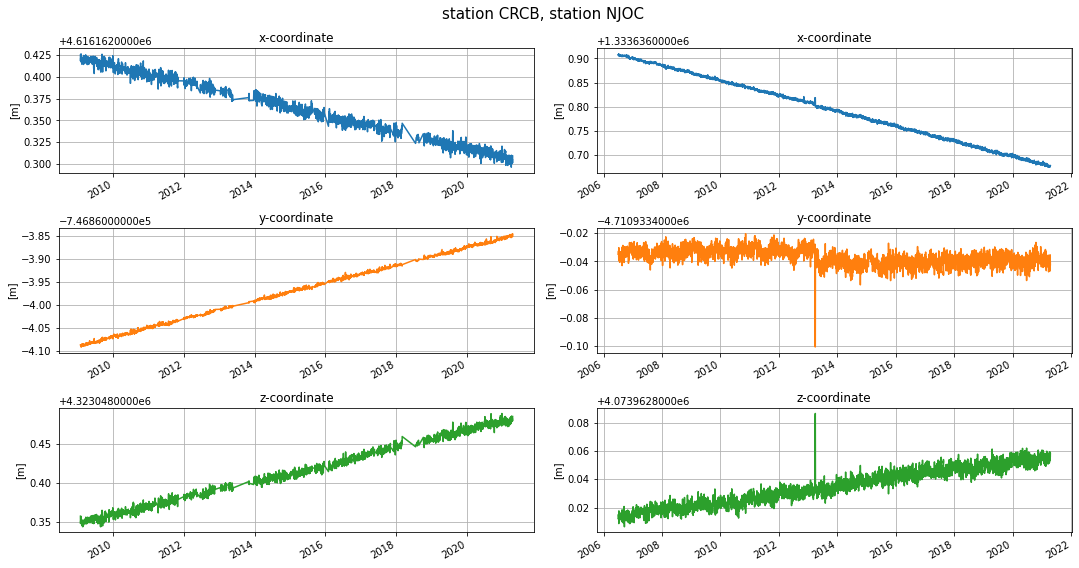

In [4]:
# plot time series to inspect the data
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,8))
stationEU['x(m)'].plot(ax=axes[0,0], color='C0', title='x-coordinate', ylabel='[m]', grid=True)
stationEU['y(m)'].plot(ax=axes[1,0], color='C1', title='y-coordinate', ylabel='[m]', grid=True)
stationEU['z(m)'].plot(ax=axes[2,0], color='C2', title='z-coordinate', ylabel='[m]', grid=True)
stationNA['x(m)'].plot(ax=axes[0,1], color='C0', title='x-coordinate', ylabel='[m]', grid=True)
stationNA['y(m)'].plot(ax=axes[1,1], color='C1', title='y-coordinate', ylabel='[m]', grid=True)
stationNA['z(m)'].plot(ax=axes[2,1], color='C2', title='z-coordinate', ylabel='[m]', grid=True)
plt.suptitle('station {}, station {}'.format(stationEU.name, stationNA.name), fontsize=15)
plt.tight_layout()

# What do you see?
- How do the time series look like?
- What can you say about them by visually inspecting them?
- How long are the time series?
- Are there any outliers or breaks in the time series? How do we deal with that?
- ...

# Outlier elimination

Idea: 
- First, we calculate a floating median of the time series. This is done because the median is robust against outliers. 
- Based on the difference between the floating median and the observations we can decide if they are outliers or not.
- Therefore, we need to know the noise floor of the time series. This can be calculated based on the median of a floating standard deviation.

Alternatively, you could do an iterative least squares adjustment including outlier detection.

In [5]:
# generate equidistant time series (missing values)
EU_idx = pd.date_range(stationEU.index[0], stationEU.index[-1], freq='D')
NA_idx = pd.date_range(stationNA.index[0], stationNA.index[-1], freq='D')

col_xyz = ['x(m)', 'y(m)', 'z(m)']
stationNA = stationNA[col_xyz].reindex(NA_idx)
stationEU = stationEU[col_xyz].reindex(EU_idx)

stationNA

x(m)          y(m)          z(m)
2006-07-03  1.333637e+06 -4.710933e+06  4.073963e+06
2006-07-04           NaN           NaN           NaN
2006-07-05  1.333637e+06 -4.710933e+06  4.073963e+06
2006-07-06           NaN           NaN           NaN
2006-07-07           NaN           NaN           NaN
...                  ...           ...           ...
2021-04-13  1.333637e+06 -4.710933e+06  4.073963e+06
2021-04-14  1.333637e+06 -4.710933e+06  4.073963e+06
2021-04-15  1.333637e+06 -4.710933e+06  4.073963e+06
2021-04-16  1.333637e+06 -4.710933e+06  4.073963e+06
2021-04-17  1.333637e+06 -4.710933e+06  4.073963e+06

[5403 rows x 3 columns]

In [6]:
# calculate floating median
col_median = ['median_x', 'median_y', 'median_z']
stationNA[col_median] = stationNA[col_xyz].rolling(window=30, center=True, min_periods=15).median()
stationEU[col_median] = stationEU[col_xyz].rolling(window=30, center=True, min_periods=15).median()

# interpolate floating median
stationNA[col_median] = stationNA[col_median].interpolate(limit_direction='both')
stationEU[col_median] = stationEU[col_median].interpolate(limit_direction='both')

stationNA.head()

x(m)          y(m)          z(m)      median_x  \
2006-07-03  1.333637e+06 -4.710933e+06  4.073963e+06  1.333637e+06   
2006-07-04           NaN           NaN           NaN  1.333637e+06   
2006-07-05  1.333637e+06 -4.710933e+06  4.073963e+06  1.333637e+06   
2006-07-06           NaN           NaN           NaN  1.333637e+06   
2006-07-07           NaN           NaN           NaN  1.333637e+06   

                median_y      median_z  
2006-07-03 -4.710933e+06  4.073963e+06  
2006-07-04 -4.710933e+06  4.073963e+06  
2006-07-05 -4.710933e+06  4.073963e+06  
2006-07-06 -4.710933e+06  4.073963e+06  
2006-07-07 -4.710933e+06  4.073963e+06

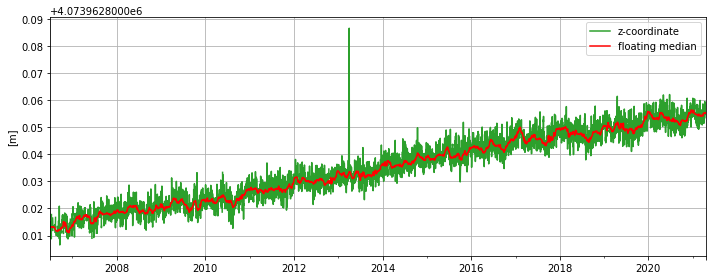

In [7]:
# plot
plt.figure()
stationNA['z(m)'].plot(figsize=(10, 4), label='z-coordinate', ylabel='[m]', color='tab:green')
stationNA['median_z'].plot(label='floating median', grid=True, color='r')
plt.legend()
plt.tight_layout()

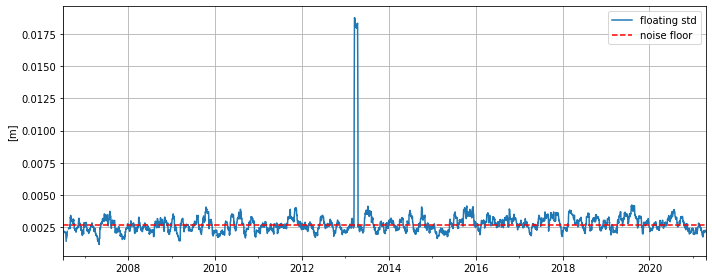

In [8]:
# calculate floating std, then take median to get noise floor
col_std = ['std_x', 'std_y', 'std_z']
stationNA[col_std] = stationNA[col_xyz].rolling(window=30, center=True, min_periods=15).std()
stationEU[col_std] = stationEU[col_xyz].rolling(window=30, center=True, min_periods=15).std()
# noise floor
noise_floor_NA = stationNA[col_std].median()
noise_floor_EU = stationEU[col_std].median()

# plot
plt.figure()
stationNA['std_z'].plot(figsize=(10, 4), label='floating std', grid=True, ylabel=['m'])
plt.axhline(noise_floor_NA['std_z'], color='r', linestyle='--', label='noise floor')
plt.legend()
plt.tight_layout()

In [9]:
# subtract floating median of coordinates
stationNA[['x_diff', 'y_diff', 'z_diff']] = (stationNA[col_xyz].values - stationNA[col_median].values)
stationEU[['x_diff', 'y_diff', 'z_diff']] = (stationEU[col_xyz].values - stationEU[col_median].values)

# if the absolute difference is bigger than 3-times the noise floor, we assume an outlier occurs
stationNA['outliers_x'] = stationNA['x_diff'].abs() > 3 * noise_floor_NA['std_x']
stationNA['outliers_y'] = stationNA['y_diff'].abs() > 3 * noise_floor_NA['std_y']
stationNA['outliers_z'] = stationNA['z_diff'].abs() > 3 * noise_floor_NA['std_z']
stationEU['outliers_x'] = stationEU['x_diff'].abs() > 3 * noise_floor_EU['std_x']
stationEU['outliers_y'] = stationEU['y_diff'].abs() > 3 * noise_floor_EU['std_y']
stationEU['outliers_z'] = stationEU['z_diff'].abs() > 3 * noise_floor_EU['std_z']

# if in one coordinate an outlier occurs, we flag all three coordinates as outlier
stationNA['outliers'] = stationNA[['outliers_x', 'outliers_y', 'outliers_z']].any(axis=1)
stationEU['outliers'] = stationEU[['outliers_x', 'outliers_y', 'outliers_z']].any(axis=1)

stationNA.head()

x(m)          y(m)          z(m)      median_x  \
2006-07-03  1.333637e+06 -4.710933e+06  4.073963e+06  1.333637e+06   
2006-07-04           NaN           NaN           NaN  1.333637e+06   
2006-07-05  1.333637e+06 -4.710933e+06  4.073963e+06  1.333637e+06   
2006-07-06           NaN           NaN           NaN  1.333637e+06   
2006-07-07           NaN           NaN           NaN  1.333637e+06   

                median_y      median_z  std_x  std_y  std_z    x_diff  \
2006-07-03 -4.710933e+06  4.073963e+06    NaN    NaN    NaN  0.000261   
2006-07-04 -4.710933e+06  4.073963e+06    NaN    NaN    NaN       NaN   
2006-07-05 -4.710933e+06  4.073963e+06    NaN    NaN    NaN -0.001273   
2006-07-06 -4.710933e+06  4.073963e+06    NaN    NaN    NaN       NaN   
2006-07-07 -4.710933e+06  4.073963e+06    NaN    NaN    NaN       NaN   

              y_diff    z_diff  outliers_x  outliers_y  outliers_z  outliers  
2006-07-03  0.000000  0.001614       False       False       False     False  
2006-07-04       NaN       NaN       False       False       False     False  
2006-07-05  0.002006 -0.001194       False       False       False     False  
2006-07-06       NaN       NaN       False       False       False     False  
2006-07-07       NaN       NaN       False       False       False     False

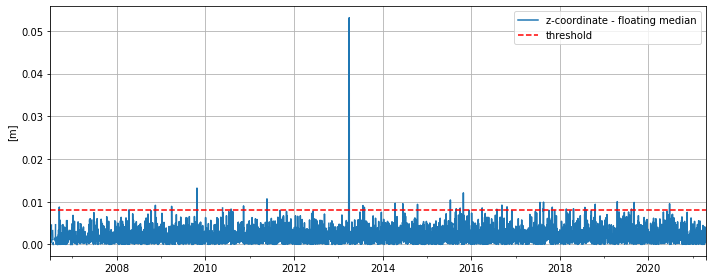

In [10]:
# plot
plt.figure()
stationNA['z_diff'].abs().plot(figsize=(10, 4), label='z-coordinate - floating median', ylabel='[m]', grid=True)
plt.axhline(3*noise_floor_NA['std_z'], color='r', linestyle='--', label='threshold')
plt.legend()
plt.tight_layout()

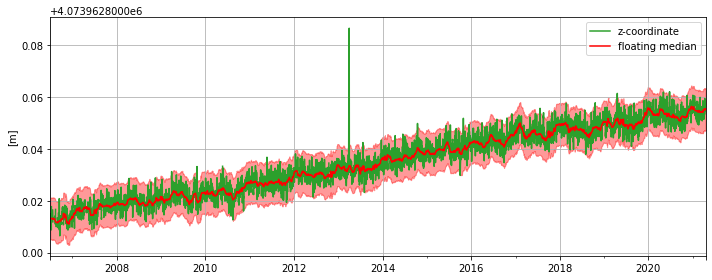

In [11]:
# plot
plt.figure()
stationNA['z(m)'].plot(figsize=(10, 4), label='z-coordinate', ylabel='[m]', color='tab:green')
stationNA['median_z'].plot(label='floating median', grid=True, color='r')
plt.fill_between(stationNA['median_z'].index, stationNA['median_z']+3*noise_floor_NA['std_z'], stationNA['median_z']-3*noise_floor_NA['std_z'], color='r', alpha=0.4)
plt.legend()
plt.tight_layout()

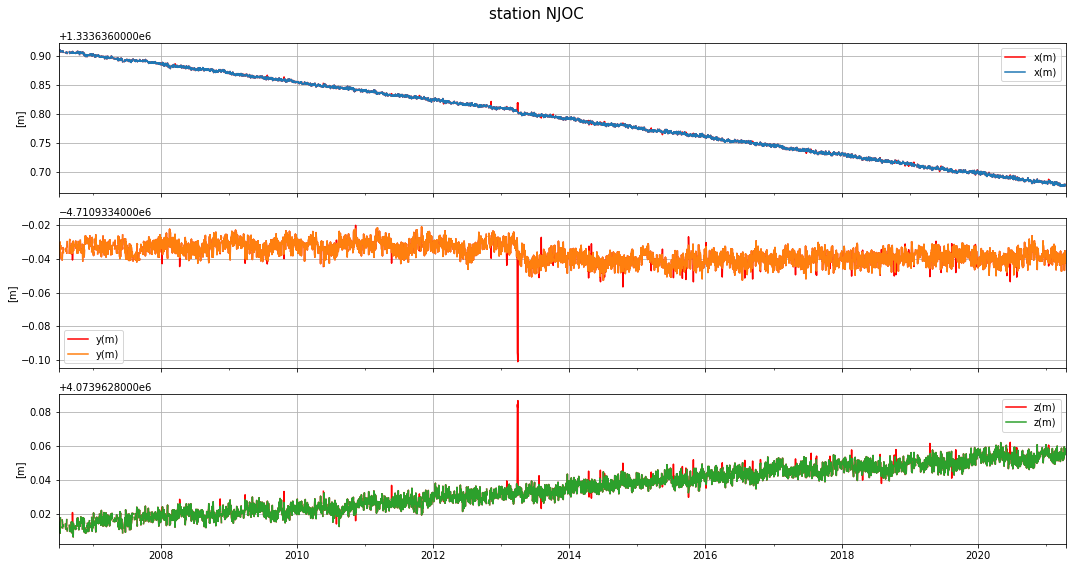

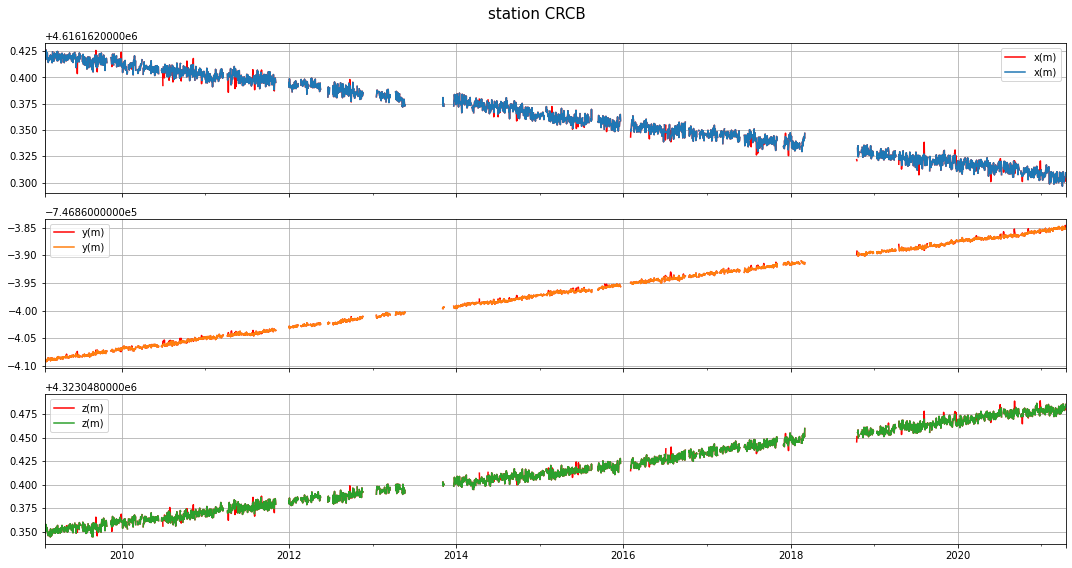

In [11]:
# plot
(ax1, ax2, ax3) = stationNA[col_xyz].plot(subplots=True, figsize=(15, 8), color='r', ylabel=['m'])
# delete outliers
stationNA = stationNA[~stationNA['outliers']]
stationNA[col_xyz].plot(subplots=True, ax=(ax1, ax2, ax3), color=['C0', 'C1', 'C2'], linewidth=1.5, grid=True)
plt.suptitle('station NJOC', fontsize=15)
plt.tight_layout()

(ax1, ax2, ax3) = stationEU[col_xyz].plot(subplots=True, figsize=(15, 8), color='r')
# delete outliers
stationEU = stationEU[~stationEU['outliers']]
stationEU[col_xyz].plot(subplots=True, ax=(ax1, ax2, ax3), color=['C0', 'C1', 'C2'], linewidth=1.5, grid=True)
plt.suptitle('station CRCB', fontsize=15)
plt.tight_layout()

# Now we can start with the actual task ...
1. Calculate differential coordinates
2. Calculate baseline
3. Calculate trend

**$\rightarrow$ How much do the tectonic plates move apart?**

# Calculate differential coordinates: $\Delta$x, $\Delta$y, $\Delta$z
$\Delta x = x_{EU}-x_{NA}$

$\Delta y = y_{EU}-y_{NA}$

$\Delta z = x_{EU}-z_{NA}$

In [13]:
# calculate differential coordinates
delta = stationEU[col_xyz] - stationNA[col_xyz]
delta.dropna(inplace=True)  # drop NaN values
delta.head()

x(m)          y(m)           z(m)
2009-01-29  3.282526e+06  3.964069e+06  249085.535988
2009-01-30  3.282526e+06  3.964069e+06  249085.525871
2009-01-31  3.282526e+06  3.964069e+06  249085.531168
2009-02-01  3.282526e+06  3.964069e+06  249085.530313
2009-02-02  3.282526e+06  3.964069e+06  249085.530315

# Calculate baseline
$baseline=\sqrt{\Delta x²+ \Delta y²+ \Delta z²}$ 

In [14]:
# calculate baseline
delta['bl'] = np.sqrt((delta ** 2).sum(axis=1))
delta['bl0'] = delta['bl'] - delta.loc[delta.index[0], 'bl']
delta.head()

x(m)          y(m)           z(m)            bl       bl0
2009-01-29  3.282526e+06  3.964069e+06  249085.535988  5.152753e+06  0.000000
2009-01-30  3.282526e+06  3.964069e+06  249085.525871  5.152753e+06 -0.003985
2009-01-31  3.282526e+06  3.964069e+06  249085.531168  5.152753e+06 -0.002716
2009-02-01  3.282526e+06  3.964069e+06  249085.530313  5.152753e+06 -0.003750
2009-02-02  3.282526e+06  3.964069e+06  249085.530315  5.152753e+06 -0.006740

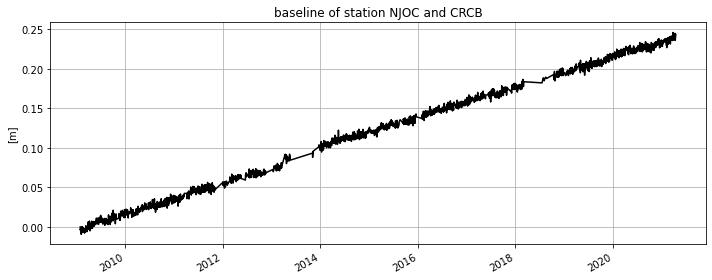

In [15]:
# plot
plt.figure(figsize=(10,4))
delta['bl0'].plot(title='baseline of station NJOC and CRCB',  ylabel='[m]', color='k')
plt.grid()
plt.tight_layout()

# Calculate trend
$trend=slope \cdot x+intercept$

You can use the _linregress()_ function of scipy or you use _Polynomial.fit()_ of numpy

In [17]:
# calculate trend using scipy.stats.linregress() 
delta['days'] = date2num(delta.index)
res = stats.linregress(x=delta['days'], y=delta['bl0'])
delta['bl_fit'] = res.intercept + res.slope*delta['days']
trend = res.slope * 365.2425 * 100  # [cm/year]

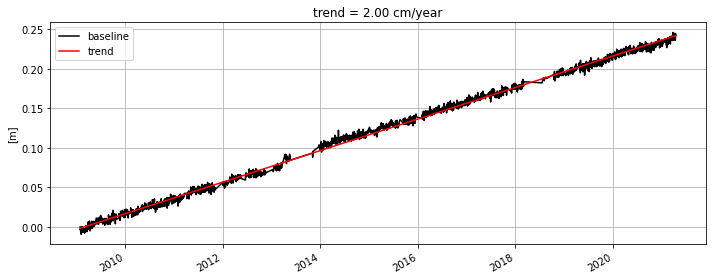

In [18]:
# plot
plt.figure(figsize=(10,4))
delta['bl0'].plot(title='trend = {:.2f} cm/year'.format(trend), label='baseline', ylabel='[m]', color='k')
delta['bl_fit'].plot(color='r', grid=True, label='trend')
plt.legend()
plt.tight_layout()

In [18]:
# calculate trend using np.polynomial.polynomial.Polynomial.fit()
delta['days'] = date2num(delta.index)
poly = np.polynomial.polynomial.Polynomial.fit(x=delta['days'], y=delta['bl0'], deg=1)
delta['bl_fit'] = poly(delta['days'])
trend = poly.coef[0] * 365.2425 * 100
coef = poly.convert().coef
trend = coef[1] * 365.2425 * 100  # [cm/year]

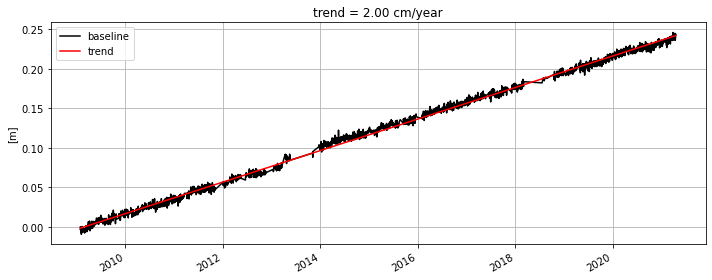

In [19]:
# plot
plt.figure(figsize=(10,4))
delta['bl0'].plot(title='trend = {:.2f} cm/year'.format(trend), label='baseline', ylabel='[m]', color='k')
delta['bl_fit'].plot(color='r', grid=True, label='trend')
plt.legend()
plt.tight_layout()

# Any questions?